In [10]:
# general
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split,StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import keras.callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier

# modelling stuff 
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import keras.callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier



In [2]:
with open('shipsnet.json') as data_file:
    dataset = json.load(data_file)
Shipsnet= pd.DataFrame(dataset)
print(Shipsnet.head())
print('')
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of NoShip Images: {}'.format(np.sum(b==0)))
    print('Number of Ship Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(x,y)


                                                data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007  

Total number of images: 4000
Number of NoShip Images: 3000
Number of Ship Images: 1000
Percentage of positive images: 25.00%
Image shape (Width, Height, Channels): (19200,)


In [3]:
xReshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
yReshaped = to_categorical(y, num_classes=2)
print("Data Shape",x.shape)
print('Labels Shape',y.shape)
print('Reshaped Data Shape',xReshaped.shape)
print('Reshaped Labels Shape',yReshaped.shape)
def describeDataset(features,labels):
    print("\n'X' shape: %s."%(features.shape,))
    print("\n'y' shape: %s."%(labels.shape,))
    print("\nUnique elements in y: %s"%(np.unique(y)))
describeDataset(xReshaped,yReshaped)

Data Shape (4000, 19200)
Labels Shape (4000,)
Reshaped Data Shape (4000, 80, 80, 3)
Reshaped Labels Shape (4000, 2)

'X' shape: (4000, 80, 80, 3).

'y' shape: (4000, 2).

Unique elements in y: [0 1]


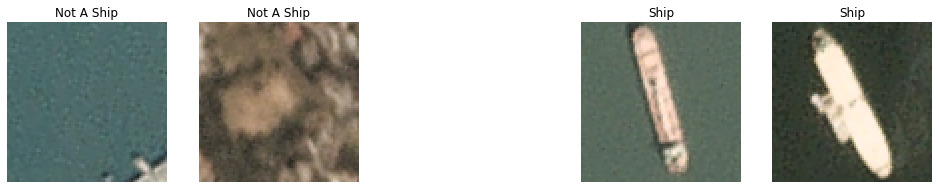

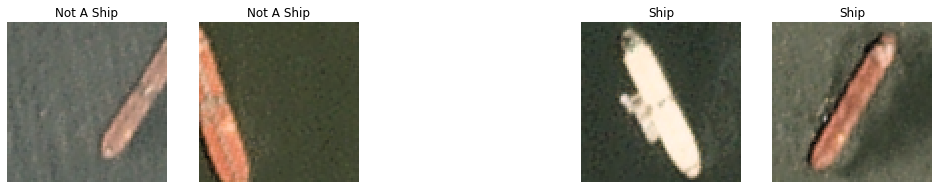

In [4]:
imgs0 = xReshaped[y==0] 
imgs1 = xReshaped[y==1] 

def plotTwo(a,b):
    for row in range(2):
        plt.figure(figsize=(20,20))
        for col in range(2):
            plt.subplot(1,6,col+1)
            plt.title('Not A Ship')
            plt.imshow(a[1000*row+col])
            plt.axis('off')       
            plt.subplot(1,6,col+4)
            plt.title('Ship')
            plt.imshow(b[100+row+col])
            plt.axis('off')

plotTwo(imgs0, imgs1)


In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2 ,random_state = 123)
x_trainReshaped,x_testReshaped,y_trainReshaped,y_testReshaped = train_test_split(xReshaped,yReshaped,test_size = 0.2 ,random_state = 123)



In [6]:
def accplot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### DL

In [7]:
%%time

indexes = np.arange(4000)
np.random.shuffle(indexes)

X_train_d = x[indexes].reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
X_train_d = X_train_d / 255
y_train = y[indexes]

def create_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), padding='same', input_shape=(80, 80, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'])
    
    return model
    
model = KerasClassifier(build_fn=create_model)

history = model.fit(X_train_d, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=1)


Train on 2679 samples, validate on 1321 samples
Epoch 1/20
2679/2679 [==============================] - 48s 18ms/step - loss: 0.4202 - accuracy: 0.8216 - val_loss: 0.2306 - val_accuracy: 0.8986
Epoch 2/20
2679/2679 [==============================] - 54s 20ms/step - loss: 0.2187 - accuracy: 0.9063 - val_loss: 0.1780 - val_accuracy: 0.9334
Epoch 3/20
2679/2679 [==============================] - 50s 19ms/step - loss: 0.1711 - accuracy: 0.9354 - val_loss: 0.1205 - val_accuracy: 0.9553
Epoch 4/20
2679/2679 [==============================] - 49s 18ms/step - loss: 0.1126 - accuracy: 0.9567 - val_loss: 0.0780 - val_accuracy: 0.9803
Epoch 5/20
2679/2679 [==============================] - 51s 19ms/step - loss: 0.0747 - accuracy: 0.9739 - val_loss: 0.0949 - val_accuracy: 0.9561
Epoch 6/20
2679/2679 [==============================] - 54s 20ms/step - loss: 0.0692 - accuracy: 0.9754 - val_loss: 0.0434 - val_accuracy: 0.9849
Epoch 7/20
2679/2679 [==============================] - 58s 22ms/step - loss

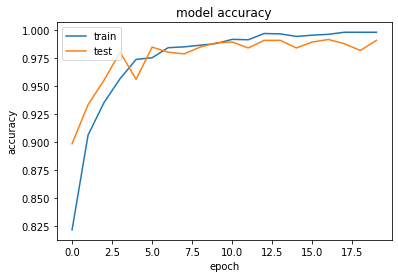

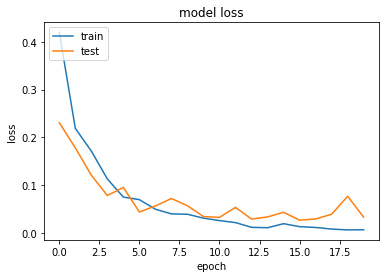

In [9]:
accplot(history)

In [34]:
%%time

indexes = np.arange(4000)
np.random.shuffle(indexes)

X_train_d = x[indexes].reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
X_train_d = X_train_d / 255
y_train = y[indexes]

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
    model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'])
    
    return model
    
model = KerasClassifier(build_fn=create_model)

history1 = model.fit(X_train_d, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=1)


Train on 2679 samples, validate on 1321 samples
Epoch 1/20
2679/2679 [==============================] - 15s 5ms/step - loss: 0.4402 - accuracy: 0.8048 - val_loss: 0.2733 - val_accuracy: 0.8940
Epoch 2/20
2679/2679 [==============================] - 15s 6ms/step - loss: 0.2254 - accuracy: 0.9048 - val_loss: 0.1410 - val_accuracy: 0.9470
Epoch 3/20
2679/2679 [==============================] - 16s 6ms/step - loss: 0.1653 - accuracy: 0.9324 - val_loss: 0.1124 - val_accuracy: 0.9629
Epoch 4/20
2679/2679 [==============================] - 17s 6ms/step - loss: 0.1179 - accuracy: 0.9556 - val_loss: 0.1522 - val_accuracy: 0.9432
Epoch 5/20
2679/2679 [==============================] - 16s 6ms/step - loss: 0.1116 - accuracy: 0.9578 - val_loss: 0.0752 - val_accuracy: 0.9743
Epoch 6/20
2679/2679 [==============================] - 18s 7ms/step - loss: 0.1062 - accuracy: 0.9619 - val_loss: 0.0866 - val_accuracy: 0.9735
Epoch 7/20
2679/2679 [==============================] - 17s 7ms/step - loss: 0.072

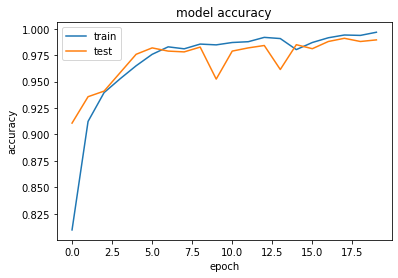

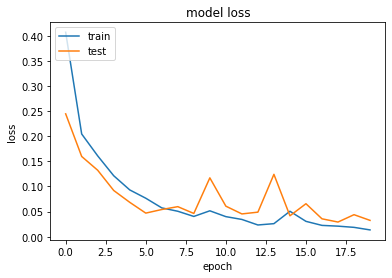

In [24]:
accplot(history1)

In [12]:
%%time 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2 ,random_state = 123)

a,b,c,d = x_train,y_train,x_test,y_test 
print('\nCompare Multiple Classifiers:')
print('\nK-Fold Cross-Validation Accuracy:\n')
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
resultsAccuracy = []
names = []

for name, model in models:
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy',n_jobs=-1)
    resultsAccuracy.append(accuracy_results)
    names.append(name)
    accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
    print(accuracyMessage)



Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:



/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR: 0.892813 (0.011358)
RF: 0.957812 (0.014938)
KNN: 0.930000 (0.015947)
CPU times: user 1min 6s, sys: 5.53 s, total: 1min 11s
Wall time: 4min 13s


In [16]:
results_cnn = [0.98625, 0.99,    0.97875, 0.98375, 0.98   ]
names

['LR', 'RF', 'KNN']

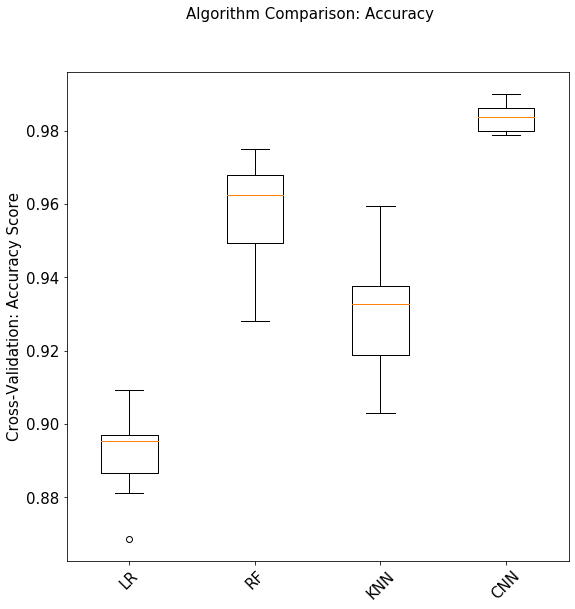

In [32]:
res1 = resultsAccuracy[0:4]
# res1.append(results_cnn)

nam1 = [ 'LR', 'RF', 'KNN','CNN']

fig = plt.figure(figsize=(9,9))
fig.suptitle('Algorithm Comparison: Accuracy',fontsize=15)
ax = fig.add_subplot(111)
plt.boxplot(res1)
ax.set_xticklabels(nam1,fontsize=15,rotation=45)
ax.set_ylabel('Cross-Validation: Accuracy Score',fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.show()


In [30]:
resultsAccuracy

[array([0.90625 , 0.86875 , 0.88125 , 0.896875, 0.884375, 0.89375 ,
        0.909375, 0.896875, 0.89375 , 0.896875]),
 array([0.928125, 0.9625  , 0.95625 , 0.975   , 0.96875 , 0.9375  ,
        0.965625, 0.975   , 0.946875, 0.9625  ]),
 array([0.9375  , 0.94375 , 0.903125, 0.909375, 0.959375, 0.928125,
        0.9375  , 0.934375, 0.915625, 0.93125 ]),
 [0.98625, 0.99, 0.97875, 0.98375, 0.98],
 [0.98625, 0.99, 0.97875, 0.98375, 0.98]]

# Additional EDA

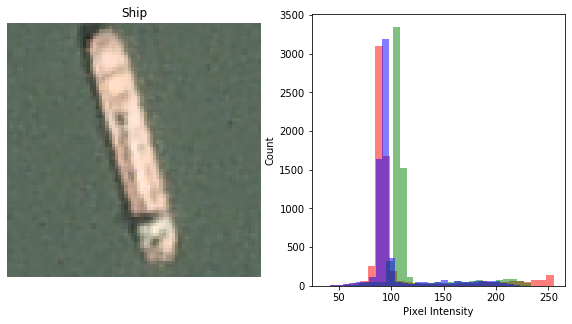

In [35]:
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('Ship' if y[1] else 'Not A Ship')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(xReshaped[100])

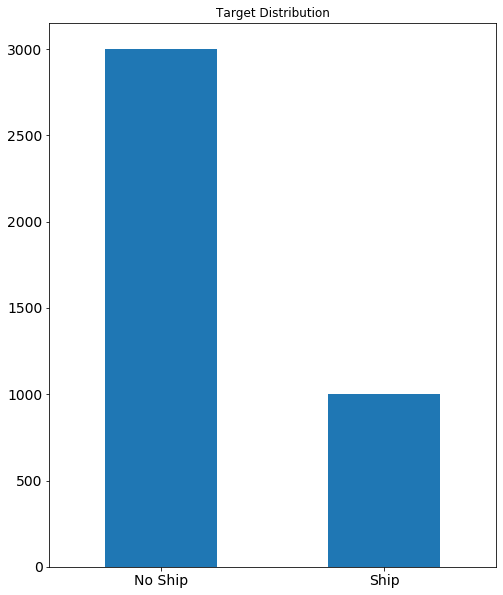

In [36]:
dist = pd.Series([len(imgs0)],index=['No Ship' ])

dist['Ship'] = len(imgs1)
plt.figure(figsize=(8,10))

dist.plot.bar()
plt.xticks(rotation=0,fontsize=14)
plt.yticks(rotation=0,fontsize=14)
plt.title('Target Distribution')
plt.show()